In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import keras

In [11]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib

DB_PATH = "../db/QuakeCast.sqlite3"   # <- your .sqlite/.db file
k_fold = 5

# --- 1) Read & join EVENT + READINGS ---
sql = """
SELECT
  e.EventID            AS event_id,
  e.Magnitude          AS mag,
  e.Longitude          AS longitude,
  e.Latitude           AS latitude,
  e.Depth              AS "depth (km)",
  r.SiteName               AS code,                -- station code (optional OHE later)
  r.Distance           AS "distance (km)",
  r.vs30               AS vs30,
  r.pga                AS "pga (%g)",
  r.pgv                AS "pgv (cm/s)"
FROM EVENT    AS e
JOIN READINGS AS r
  ON r.EventID = e.EventID
"""
with sqlite3.connect(DB_PATH) as con:
    df = pd.read_sql_query(sql, con)

# --- 2) Clean/filter like your CSV workflow ---
# Drop rows that are missing any of the needed fields
needed = ["mag","longitude","latitude","depth (km)","distance (km)","vs30","pga (%g)","pgv (cm/s)"]
df = df.dropna(subset=needed)

# Same PGA filter you had
df = df[df["pga (%g)"] <= 1]

# OPTIONAL: one-hot encode station code if you want it as a feature
# df["code"] = df["code"].astype(str)
# df = pd.get_dummies(df, columns=["code"])

# --- 3) Build features/targets (same names as before) ---
features = ["mag", "longitude", "latitude", "depth (km)", "distance (km)", "vs30"]
X = df[features]
Y = df[["pga (%g)", "pgv (cm/s)"]]   # multi-output target

print(X,Y)

      mag  longitude  latitude  depth (km)  distance (km)    vs30
0     3.6  -153.0206   60.0317       114.0        244.329  348.35
1     3.6  -153.0206   60.0317       114.0        238.231  326.45
2     3.6  -153.0206   60.0317       114.0        247.943  347.43
3     3.6  -153.0206   60.0317       114.0        237.675  284.21
4     3.6  -153.0206   60.0317       114.0        240.198  272.44
...   ...        ...       ...         ...            ...     ...
8680  3.5  -153.9619   58.8726        10.2        286.555  760.00
8681  4.6  -155.6472   56.2871         6.0        441.318  760.00
8682  4.6  -155.6472   56.2871         6.0        438.779  760.00
8683  4.6  -155.6472   56.2871         6.0        331.737  760.00
8684  4.6  -155.6472   56.2871         6.0        177.649  593.79

[7403 rows x 6 columns]       pga (%g)  pgv (cm/s)
0       0.0208      0.0054
1       0.0190      0.0060
2       0.0403      0.0055
3       0.0300      0.0119
4       0.0270      0.0085
...        ...       

In [12]:
# df = pd.read_csv("../db/StationsBeta5.csv")
# df = df.dropna()


# df = df[df["pga (%g)"] <= 1]
# k_fold = 5
# # # Ensure code is categorical string
# #df["code"] = df["code"].astype(str)

# # # One-hot encode station code
# #df = pd.get_dummies(df, columns=["code"])

# # Now update X to include new one-hot columns
# features = ["mag", "longitude", "latitude", "depth (km)", "distance (km)", "vs30"] 
# #station_features = [c for c in df.columns if c.startswith("code_")]

# X = df[features]

# # df["log_pga"] = np.log10(df["pga (%g)"])
# # df["log_pgv"] = np.log10(df["pgv (cm/s)"])
# Y = df[["pga (%g)", "pgv (cm/s)"]] 
# std_dev = df["pga (%g)"].std()
# print(std_dev)

# print(X,Y)

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt

# # pick your target column
# col = "pga (%g)"

# # define bins (0.0 → 0.5 for example, adjust if needed)
# bin_width = 0.005
# bins = np.arange(0, df[col].max() + bin_width, bin_width)

# # cut data into bins and count
# counts, edges = np.histogram(df[col], bins=bins)
# total_points = len(df)

# # plot as bar chart
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(counts)), counts, width=0.8, align="center",
#         alpha=0.7, edgecolor="black")

# # format x-ticks as bin ranges
# labels = [f"{edges[i]:.3f}–{edges[i+1]:.3f}" for i in range(len(counts))]
# plt.xticks(range(len(counts)), labels, rotation=45, ha="right")

# # annotate counts on top of bars
# for i, c in enumerate(counts):
#     plt.text(i, c + 0.5, str(c), ha="center", va="bottom", fontsize=8)

# # add total count as a text box inside plot
# plt.text(0.99, 0.95, f"Total points: {total_points}",
#          ha="right", va="top", transform=plt.gca().transAxes,
#          fontsize=10, bbox=dict(boxstyle="round,pad=0.3",
#                                 fc="white", ec="gray", alpha=0.7))

# plt.title("Distribution of PGA (%g) by 0.005 bins")
# plt.xlabel("PGA (%g) range")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()




In [14]:
import joblib 
def kcross_validate(X, y, model_fn, splits, is_NN=False, epoch_num=100, validation_split_val=0.2, batch_size_val=16):
    kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    
    r2_scores, mae_scores, mse_scores, rmse_scores = [], [], [], []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    
        if is_NN:
            model = model_fn(X_train.shape[1]) 
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            model.fit(X_train, y_train,
                      validation_split=validation_split_val,
                      batch_size=batch_size_val,
                      epochs=epoch_num,
                      verbose=0,
                      callbacks=[early_stop])
            y_pred = model.predict(X_test).flatten()
        else:
            model = model_fn()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        
        r2_scores.append(r2_score(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))

        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
        rmse_scores.append(np.sqrt(mse))
    
    print(rmse_scores)
    print(np.mean(rmse_scores), np.std(rmse_scores))
        
  
    return {
        "R^2": [np.mean(r2_scores), np.std(r2_scores)],
        
        "MAE": [np.mean(mae_scores), np.std(mae_scores)],
        "MSE": [np.mean(mse_scores), np.std(mse_scores)], 
        "RMSE": [np.mean(rmse_scores), np.std(rmse_scores)], 
    }


In [15]:
xg = {'n_estimators': 245, 'max_depth': 9, 'learning_rate': 0.1409756734107697, 'subsample': 0.691252440051408, 'colsample_bytree': 0.8566421345399504, 'gamma': 1.6326047292240027, 'min_child_weight': 10}
rf = {'n_estimators': 176, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
svr = {'kernel': 'rbf', 'C': 9.548701845515902, 'epsilon': 0.6549422444076709, 'shrinking': True, 'tol': 1.5663918514121694e-05}
dt = {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.0019656459897571645, 'max_features': None, 'min_impurity_decrease': 0.03377942853967633, 'ccp_alpha': 0.01646768103126862 } 
knn = {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 88, 'p': 2}
gb = {'n_estimators': 425, 'learning_rate': 0.15790616598305415, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 10, 'subsample': 0.9175803351819304, 'max_features': 'log2', 'alpha': 0.5894493695230459, 'validation_fraction': 0.18492310825946917, 'n_iter_no_change': 18, 'tol': 3.9585438816141885e-05}

In [16]:
model_results = {}
models = {
    #"GradientBoosting": lambda: GradientBoostingRegressor(
    #    **gb
    #), 
    # "RandomForest": lambda: RandomForestRegressor(
    #     **rf
    # ),
    #"DecisionTree": lambda: DecisionTreeRegressor(
    #    **dt
    #),
    #"SVR": lambda: SVR(
    #    **svr
    #),
    "KNN": lambda: KNeighborsRegressor(
        **knn
    ),
    "XGBoost": lambda: xgb.XGBRegressor(
        **xg
    ),
    "LinReg": lambda: LinearRegression(),
}


for name, model in models.items():
    print(f"Evaluating {name}...")
    if name == "BPNN":
        model_results[name] = kcross_validate(
            X, Y, lambda input_dim: model(input_dim), splits=k_fold, is_NN=True
        )
    else:
            model_results[name] = kcross_validate(X, Y, model, splits=k_fold, is_NN=False)
print("\nAll Evaluations Complete!")


Evaluating KNN...
[0.03823684086674785, 0.038497187484347044, 0.03874920699355587, 0.04478750415403139, 0.047870632077323894]
0.041628274315201205 0.003963390412893764
Evaluating XGBoost...
[0.052980306131742344, 0.04769475988798199, 0.05725548680091553, 0.058381875022312305, 0.06667188834198738]
0.05659686323698791 0.0062841564632170315
Evaluating LinReg...
[0.05401756102860982, 0.050695489214052716, 0.05797619468885625, 0.06102694025391611, 0.06639041630350079]
0.058021320297787136 0.005454822544263873

All Evaluations Complete!


In [17]:
print(model_results.items())
best_model_name = None
best_rmse = float('inf')
results_summary = []

for name, results in model_results.items():
    # Extract RMSE mean value (first element in the RMSE list)
    rmse_mean = results['RMSE'][0]  # Mean RMSE
    rmse_std = results['RMSE'][1]   # Standard deviation of RMSE
    
    results_summary.append((name, rmse_mean, rmse_std))
    
    # Check if this is the best model (lowest RMSE)
    if rmse_mean < best_rmse:
        best_rmse = rmse_mean
        best_model_name = name

best_model = models[best_model_name]()
print(best_model_name)

joblib.dump(best_model, "best_model.pkl")

dict_items([('KNN', {'R^2': [0.6564322050284286, 0.021491236650639987], 'MAE': [0.015833998232863918, 0.0009242303028772171], 'MSE': [0.0017486216860266586, 0.0003391999801947512], 'RMSE': [0.041628274315201205, 0.003963390412893764]}), ('XGBoost', {'R^2': [0.19563736257935735, 0.023166283897321786], 'MAE': [0.02794554670113291, 0.0012356728328401804], 'MSE': [0.0032426955507205064, 0.0007212980045191133], 'RMSE': [0.05659686323698791, 0.0062841564632170315]}), ('LinReg', {'R^2': [0.31063878633431036, 0.013737549475732264], 'MAE': [0.029539565059941975, 0.000655184914096036], 'MSE': [0.0033962286980878153, 0.0006392646903301999], 'RMSE': [0.058021320297787136, 0.005454822544263873]})])
KNN


['best_model.pkl']

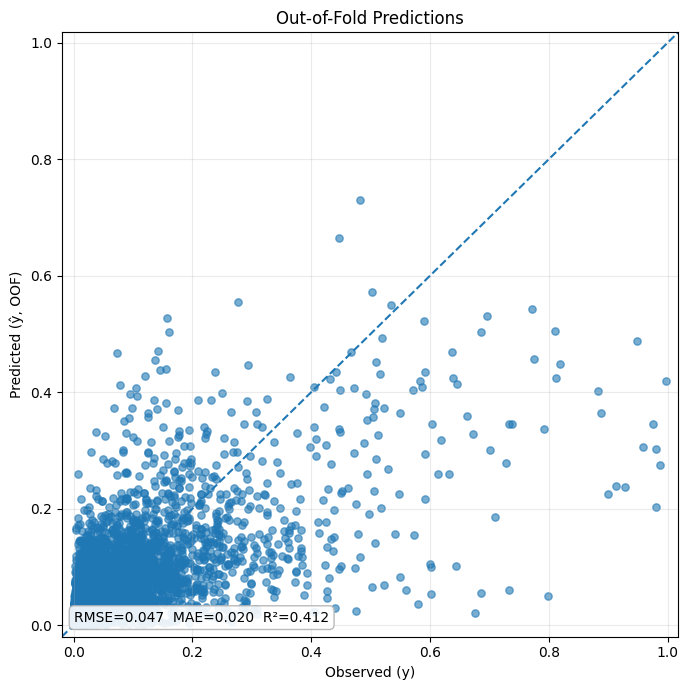

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.model_selection import KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def oof_plot(
    model,
    X,
    y,
    cv=5,
    groups=None,
    title="Out-of-Fold Predictions",
    n_jobs=-1,
    marker_size=28,
    alpha=0.6,
):
    """
    Parameters
    ----------
    model  : fitted or unfitted sklearn estimator (or Pipeline)
    X, y   : dataset (arrays or DataFrame/Series)
    cv     : int (K) or a CV splitter (e.g., KFold(...) or GroupKFold(...))
    groups : array-like of group labels if using grouped CV
    Returns
    -------
    y_oof : np.ndarray, strictly out-of-sample predictions (len = len(y))
    fig   : matplotlib Figure
    """

    # Build CV splitter
    if isinstance(cv, int):
        cv_splitter = (GroupKFold(n_splits=cv) if groups is not None
                       else KFold(n_splits=cv, shuffle=True, random_state=42))
    else:
        cv_splitter = cv

    # Get OOF predictions (cross_val_predict clones the estimator internally)
    y_oof = cross_val_predict(
        estimator=clone(model),
        X=X,
        y=y,
        groups=groups,
        cv=cv_splitter,
        method="predict",
        n_jobs=n_jobs,
        verbose=0,
    )

    # Metrics
    rmse = mean_squared_error(y, y_oof, squared=False)
    mae  = mean_absolute_error(y, y_oof)
    r2   = r2_score(y, y_oof)

    # Plot y vs ŷ(OOF)
    y_true = np.asarray(y).ravel()
    y_pred = np.asarray(y_oof).ravel()
    lo = np.nanmin([y_true, y_pred])
    hi = np.nanmax([y_true, y_pred])
    pad = 0.02 * (hi - lo if hi > lo else 1.0)
    lo, hi = lo - pad, hi + pad

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(y_true, y_pred, s=marker_size, alpha=alpha)
    ax.plot([lo, hi], [lo, hi], linestyle="--")
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.set_xlabel("Observed (y)")
    ax.set_ylabel("Predicted (ŷ, OOF)")
    ax.set_title(title)
    ax.grid(True, alpha=0.25)

    ax.text(
        0.02, 0.02,
        f"RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}",
        transform=ax.transAxes,
        fontsize=10,
        ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.7", alpha=0.9),
    )

    plt.tight_layout()
    return y_oof, fig

# You already have: best_model, X, Y
y_oof, fig = oof_plot(best_model, X, Y, cv=5)  # or cv=5, etc.
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

export = True
if export == True:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    bm = best_model
    bm.fit(X_train, y_train)
    joblib.dump(bm, "best_model.pkl")